<a href="https://colab.research.google.com/github/saiyuu330/COSE474_Project/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaeungyun","key":"2d6b19b1c261f1452c200ad28d1f5208"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d nqa112/vietnamese-bike-and-motorbike

100% 1.44G/1.44G [00:47<00:00, 32.1MB/s]
100% 1.44G/1.44G [00:47<00:00, 32.7MB/s]


In [4]:
!unzip -o -q /content/vietnamese-bike-and-motorbike.zip -d /content/data

In [21]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
from PIL import Image
from struct import unpack
import pathlib

In [6]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                break

In [7]:
def delete_corrupted_image(image):
    if str(image).endswith("gif"):
      return image
    else:
      check = JPEG(image)
      try:
        check.decode()
      except:
        return image

In [8]:
data_dir = pathlib.Path("/content/data")

for image in data_dir.glob("*/*"):
  corrupt = delete_corrupted_image(image)
  if corrupt is not None:
    #print(f"Delete {image}")
    image.unlink()

In [9]:
bike_count = len(list(data_dir.glob('bike/*')))
motorbike_count = len(list(data_dir.glob('motorbike/*')))
bike_count, motorbike_count

(6044, 6061)

In [35]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="/content/data", transform=transform)

12105

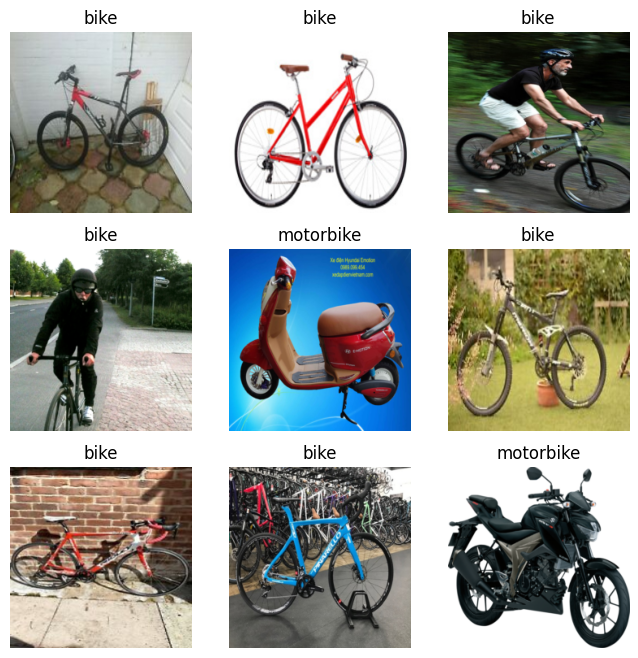

In [11]:
indices = np.random.choice(len(dataset), size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    index = indices[i]
    img, label = dataset[index]

    img = img.numpy().transpose((1, 2, 0))

    class_name = dataset.classes[label]
    ax.set_title(class_name)
    ax.imshow(img)
    ax.axis("off")

plt.show()

In [12]:
def add_gaussian_noise(image, mean=0, std=25):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, std, (row, col, ch))
    noisy_image = np.clip(image + gauss, 0, 255)
    return noisy_image.astype(np.uint8)

In [13]:
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=25):
        self.mean = mean
        self.std = std
    def __call__(self, img):
        img_array = np.array(img)
        noisy_img_array = add_gaussian_noise(img_array, mean=self.mean, std=self.std)
        noisy_img = Image.fromarray(noisy_img_array)
        return noisy_img

In [30]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    AddGaussianNoise(mean=0, std=50),
    transforms.ToTensor(),
])

noise_dataset = datasets.ImageFolder(root="/content/data", transform=transform)

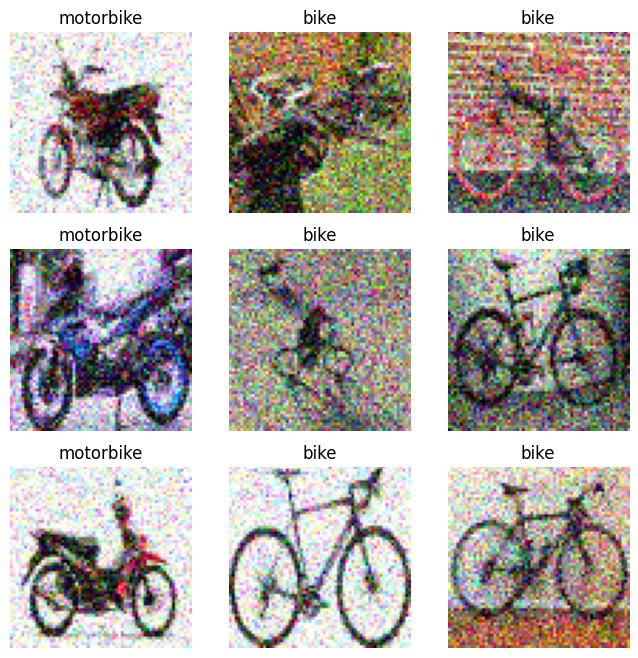

In [31]:
indices = np.random.choice(len(noise_dataset), size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    index = indices[i]
    img, label = noise_dataset[index]

    img = img.numpy().transpose((1, 2, 0))

    class_name = noise_dataset.classes[label]
    ax.set_title(class_name)
    ax.imshow(img)
    ax.axis("off")

plt.show()

In [22]:
noise_data_loader = DataLoader(noise_dataset, batch_size=32, shuffle=True, num_workers=4)

model = models.vgg16(pretrained=True)

num_classes = len(dataset.classes)
model.classifier[6] = nn.Linear(4096, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also u

Epoch 10/10, Loss: 0.04251931745686143


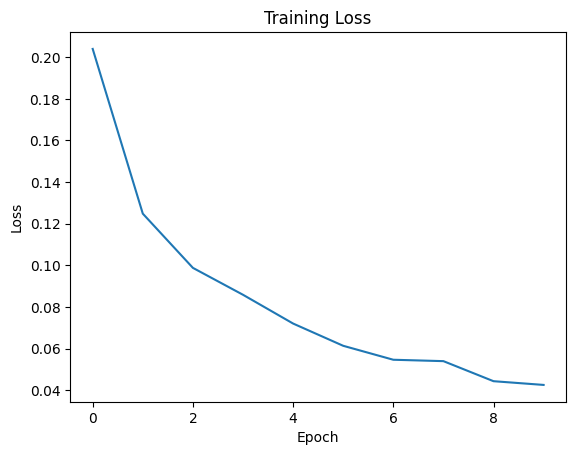

In [23]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0

    for inputs, labels in noise_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(noise_data_loader)
    losses.append(epoch_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


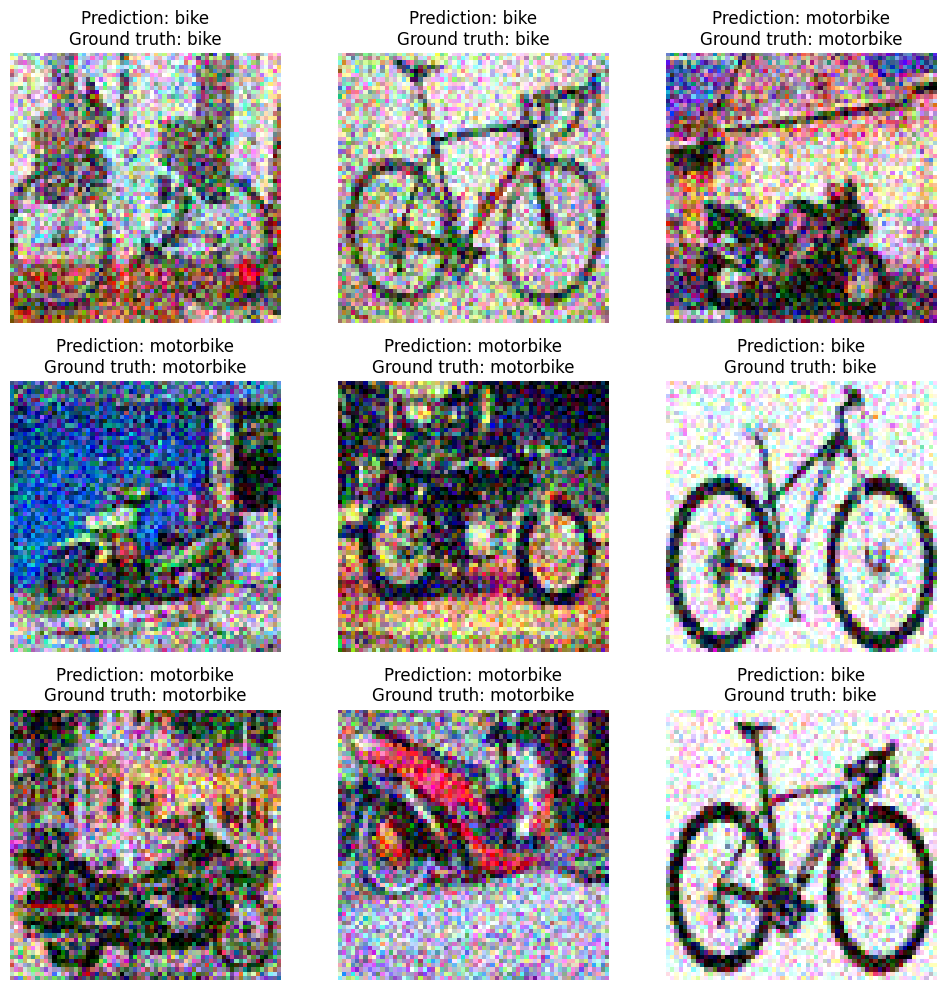

In [34]:
model.eval()

with torch.no_grad():
    sample_indices = np.random.choice(len(noise_dataset), size=9, replace=False)
    sample_loader = torch.utils.data.DataLoader(noise_dataset, batch_size=9, sampler=torch.utils.data.SubsetRandomSampler(sample_indices))

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for (inputs, labels), ax in zip(sample_loader, axes.flatten()):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        class_names = [noise_dataset.classes[i] for i in preds]
        ground_truth = [noise_dataset.classes[i] for i in labels]

        for i, ax in enumerate(axes.flatten()):
            img = transforms.ToPILImage()(inputs[i].cpu())  # 텐서를 PIL 이미지로 변환
            ax.imshow(img)
            ax.set_title(f"Prediction: {class_names[i]}\nGround truth: {ground_truth[i]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()